In [1]:
setwd('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1009. NC ENVRIOSCAN/P1009.3. Analyses/P1009.3.6. WHP & Sociodemographic Mapping')
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1009. NC ENVRIOSCAN/P1009.3. Analyses/P1009.3.6. WHP & Sociodemographic Mapping/Output')
cur_date = "062023"

library(readxl)
library(tidyverse)
library(reshape2)
library(tigris)
library(cowplot)
library(rcartocolor)
library(RColorBrewer)
library(MetBrewer)
library(tidytext)

# reading in files
whp_df = data.frame(read_excel("Input/Imputed_Wildfire_Hazard_030923.xlsx"))
ej_screen_geo_id_clusters = data.frame(read_excel("Input/GEO_ID_Sociodemographic_Clusters_030123.xlsx"))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


To enable caching of data, set `options(tigris_use_cache = TRUE)`
in your R script or .Rprofile.


Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




In [2]:
head(whp_df)

,GEO_ID,FIPS,County,Census_Tract,Avg_ACRES,Wildfire_Hazard_Potential_Mean,Wildfire_Hazard_Potential_Quintile_Number,Wildfire_Hazard_Potential_Quintile_Percentage
,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,14000US37141920201,37141920201,Pender,9202.01,596842.6,715.5177,5,0-20%
2,14000US37141920401,37141920401,Pender,9204.01,596842.6,715.5177,5,0-20%
3,14000US37141920402,37141920402,Pender,9204.02,596842.6,715.5177,5,0-20%
4,14000US37141920403,37141920403,Pender,9204.03,596842.6,715.5177,5,0-20%
5,14000US37141920601,37141920601,Pender,9206.01,596842.6,715.5177,5,0-20%
6,14000US37141990100,37141990100,Pender,9901.00,596842.6,715.5177,5,0-20%


In [3]:
# download shapefile from the tigris (census package)
nc_census_tract_shapefile = tracts(state = 37, year = 2010) %>%
    rename(FIPS = GEOID10)
nc_county_shapefile = counties(state = 37, year = 2010) %>%
    rename(FIPS = GEOID10)
head(nc_census_tract_shapefile)

  |======================================================================| 100%
  |======================================================================| 100%


Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



,STATEFP10,COUNTYFP10,TRACTCE10,FIPS,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,COUNTYFP,STATEFP,geometry
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<MULTIPOLYGON [°]>
1,37,153,970100,37153970100,9701,Census Tract 9701,G5020,S,246281647,2106825,+35.0503203,-079.6180454,153,37,MULTIPOLYGON (((-79.56729 3...
2,37,153,970200,37153970200,9702,Census Tract 9702,G5020,S,457736198,7835811,+35.0967892,-079.8225512,153,37,MULTIPOLYGON (((-79.71753 3...
3,37,153,970800,37153970800,9708,Census Tract 9708,G5020,S,139358521,2752112,+34.8508484,-079.8201950,153,37,MULTIPOLYGON (((-79.76773 3...
4,37,153,970900,37153970900,9709,Census Tract 9709,G5020,S,23311020,78240,+34.8785679,-079.7346295,153,37,MULTIPOLYGON (((-79.76773 3...
5,37,153,971000,37153971000,9710,Census Tract 9710,G5020,S,49233222,188190,+34.9395795,-079.6628977,153,37,MULTIPOLYGON (((-79.69038 3...
6,37,153,971100,37153971100,9711,Census Tract 9711,G5020,S,161136716,948938,+34.8751742,-079.6567146,153,37,MULTIPOLYGON (((-79.5684 34...


In [4]:
# first changing data type of some of the columns
whp_df$FIPS = as.character(whp_df$FIPS)
ej_screen_geo_id_clusters$Cluster = as.character(ej_screen_geo_id_clusters$Cluster)

# combining data
all_data_census_tract = full_join(whp_df, nc_census_tract_shapefile)
all_data_census_tract$Wildfire_Hazard_Potential_Quintile_Number = as.character(all_data_census_tract$Wildfire_Hazard_Potential_Quintile_Number)


# need to first make sure files are the same dimensions
county_averages_df = whp_df %>%
    group_by(County) %>%
    mutate(County_Avg_WHP_Mean = mean(Wildfire_Hazard_Potential_Mean), 
           County_Avg_WHP_Quintile = mean(Wildfire_Hazard_Potential_Quintile_Number)) %>%
    select(County, County_Avg_WHP_Mean, County_Avg_WHP_Quintile)

all_data_county = full_join(county_averages_df, nc_county_shapefile %>%
                                rename(County = NAME10))



head(all_data_census_tract)

Joining with `by = join_by(FIPS)`
Joining with `by = join_by(County)`


,GEO_ID,FIPS,County,Census_Tract,Avg_ACRES,Wildfire_Hazard_Potential_Mean,Wildfire_Hazard_Potential_Quintile_Number,Wildfire_Hazard_Potential_Quintile_Percentage,STATEFP10,COUNTYFP10,⋯,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,COUNTYFP,STATEFP,geometry
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<MULTIPOLYGON [°]>
1,14000US37141920201,37141920201,Pender,9202.01,596842.6,715.5177,5,0-20%,37,141,⋯,Census Tract 9202.01,G5020,S,21147417,44942,+34.4018480,-077.6218025,141,37,MULTIPOLYGON (((-77.66061 3...
2,14000US37141920401,37141920401,Pender,9204.01,596842.6,715.5177,5,0-20%,37,141,⋯,Census Tract 9204.01,G5020,S,75755882,15209,+34.5055979,-077.9462191,141,37,MULTIPOLYGON (((-77.94007 3...
3,14000US37141920402,37141920402,Pender,9204.02,596842.6,715.5177,5,0-20%,37,141,⋯,Census Tract 9204.02,G5020,S,65209545,12064,+34.5702392,-077.9912005,141,37,MULTIPOLYGON (((-77.92338 3...
4,14000US37141920403,37141920403,Pender,9204.03,596842.6,715.5177,5,0-20%,37,141,⋯,Census Tract 9204.03,G5020,S,106488713,1076000,+34.5493899,-077.8690183,141,37,MULTIPOLYGON (((-77.83308 3...
5,14000US37141920601,37141920601,Pender,9206.01,596842.6,715.5177,5,0-20%,37,141,⋯,Census Tract 9206.01,G5020,S,103459422,348628,+34.4486577,-077.9634232,141,37,MULTIPOLYGON (((-77.94027 3...
6,14000US37141990100,37141990100,Pender,9901.00,596842.6,715.5177,5,0-20%,37,141,⋯,Census Tract 9901,G5020,S,0,133298842,+34.3492469,-077.6031266,141,37,MULTIPOLYGON (((-77.67696 3...


Creating 4 different maps of North Carolina:

1. WHP mean by GEO id
2. WHP quintile by GEO id
3. WHP mean by County
4. WHP quintile by County
5. Clusters based on EJ Screen social stressors by GEO id
6. Clusters based on housing data by GEO id

### WHP Mean by GEO id

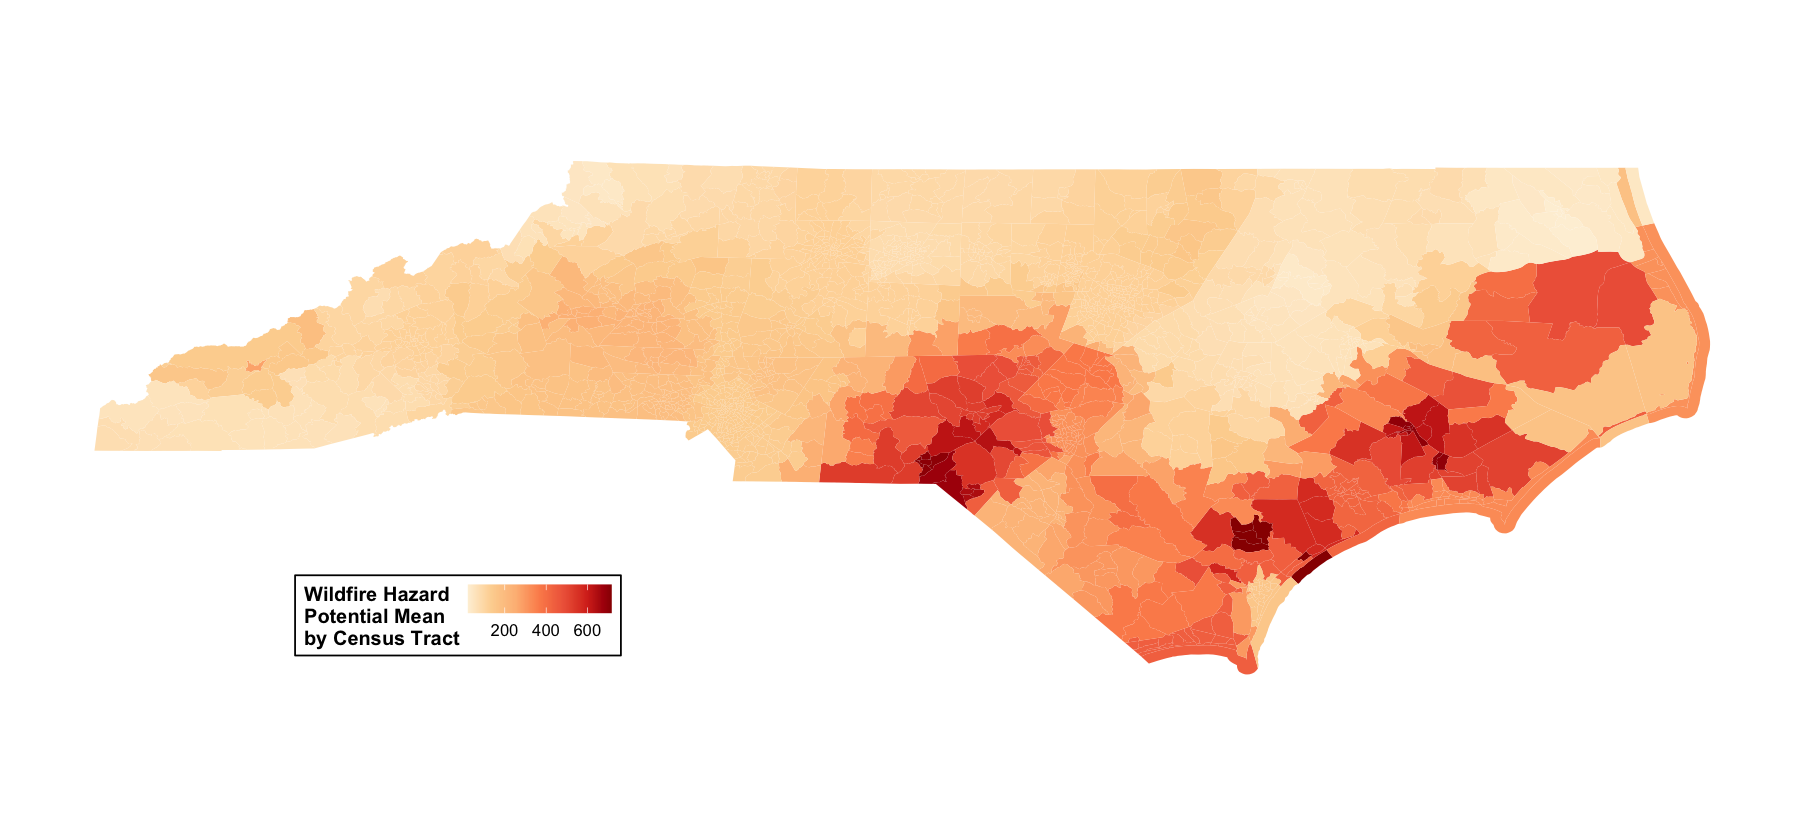

In [5]:
options(repr.plot.width = 15, repr.plot.height = 7) #changing size

# getting color palette
palette_colors = brewer.pal(7, "OrRd")

WHP_mean_GEO_ID_map = ggplot() +
  geom_sf(data = all_data_census_tract, aes(fill = Wildfire_Hazard_Potential_Mean, geometry = geometry), 
          color = NA) + # removes gray lines between geo ids

  theme_bw() + 

  theme(axis.text = element_blank(), # removes x and y labels
      axis.ticks = element_blank(),# removes ticks from x and y labels
      legend.title = element_text(face = 'bold', size = 12), # changes legend title
      legend.text = element_text(size = 10), # changes legend text
      legend.position = c(0.25,0.15), # move legend to bottom left corner
      legend.direction = "horizontal",
      legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
      panel.border = element_blank(), # removes border around the map
      panel.grid.major = element_blank(), # removes grid
      panel.grid.minor = element_blank()) + # removes grid 
  
  scale_fill_gradientn(colors = palette_colors, 
      name = "Wildfire Hazard\nPotential Mean\nby Census Tract")

WHP_mean_GEO_ID_map

### WHP Quintile by GEO id

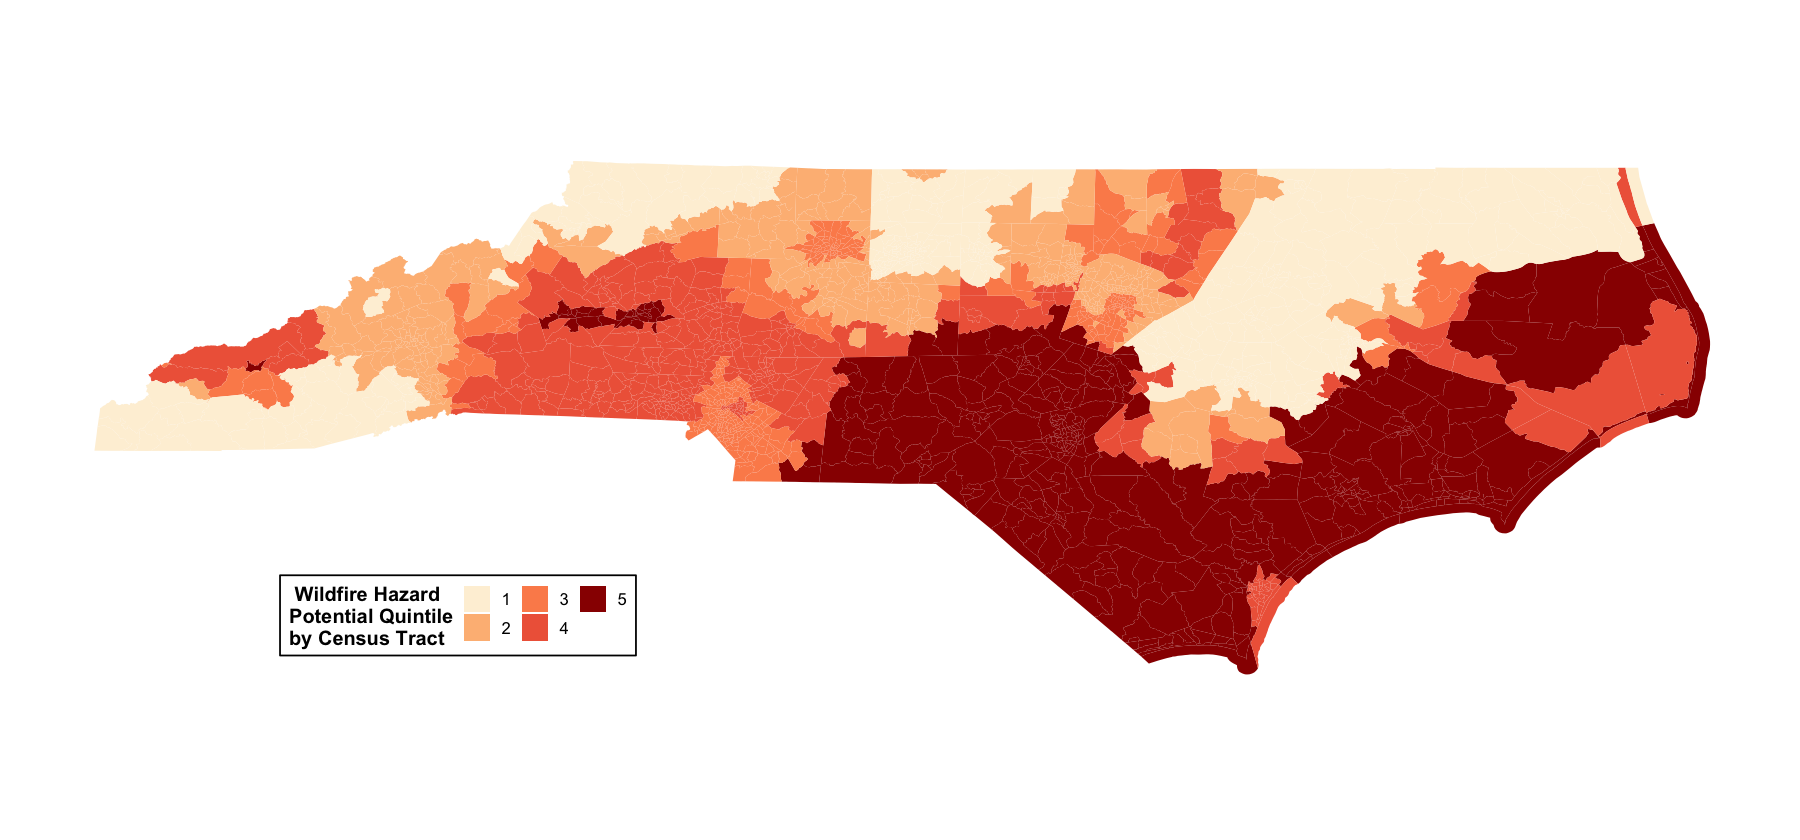

In [6]:
WHP_quintile_GEO_ID_map = ggplot() +
  geom_sf(data = all_data_census_tract, aes(fill = Wildfire_Hazard_Potential_Quintile_Number, 
                                            geometry = geometry), color = NA) + # removes gray lines between geo ids

  theme_bw() + 

  theme(axis.text = element_blank(), # removes x and y labels
      axis.ticks = element_blank(),# removes ticks from x and y labels
      legend.title = element_text(face = 'bold', size = 12), # changes legend title
      legend.text = element_text(size = 10), # changes legend text
      legend.position = c(0.25,0.15), # move legend to bottom left corner
      legend.direction = "horizontal",
      legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
      panel.border = element_blank(), # removes border around the map
      panel.grid.major = element_blank(), # removes grid
      panel.grid.minor = element_blank()) + # removes grid 

  scale_fill_manual(values = palette_colors[c(1,3:5,7)], 
                       name = " Wildfire Hazard\nPotential Quintile\nby Census Tract") + 

  guides(fill = guide_legend(nrow = 2)) # making the quintiles in the legend into rows

WHP_quintile_GEO_ID_map

### WHP Mean by County

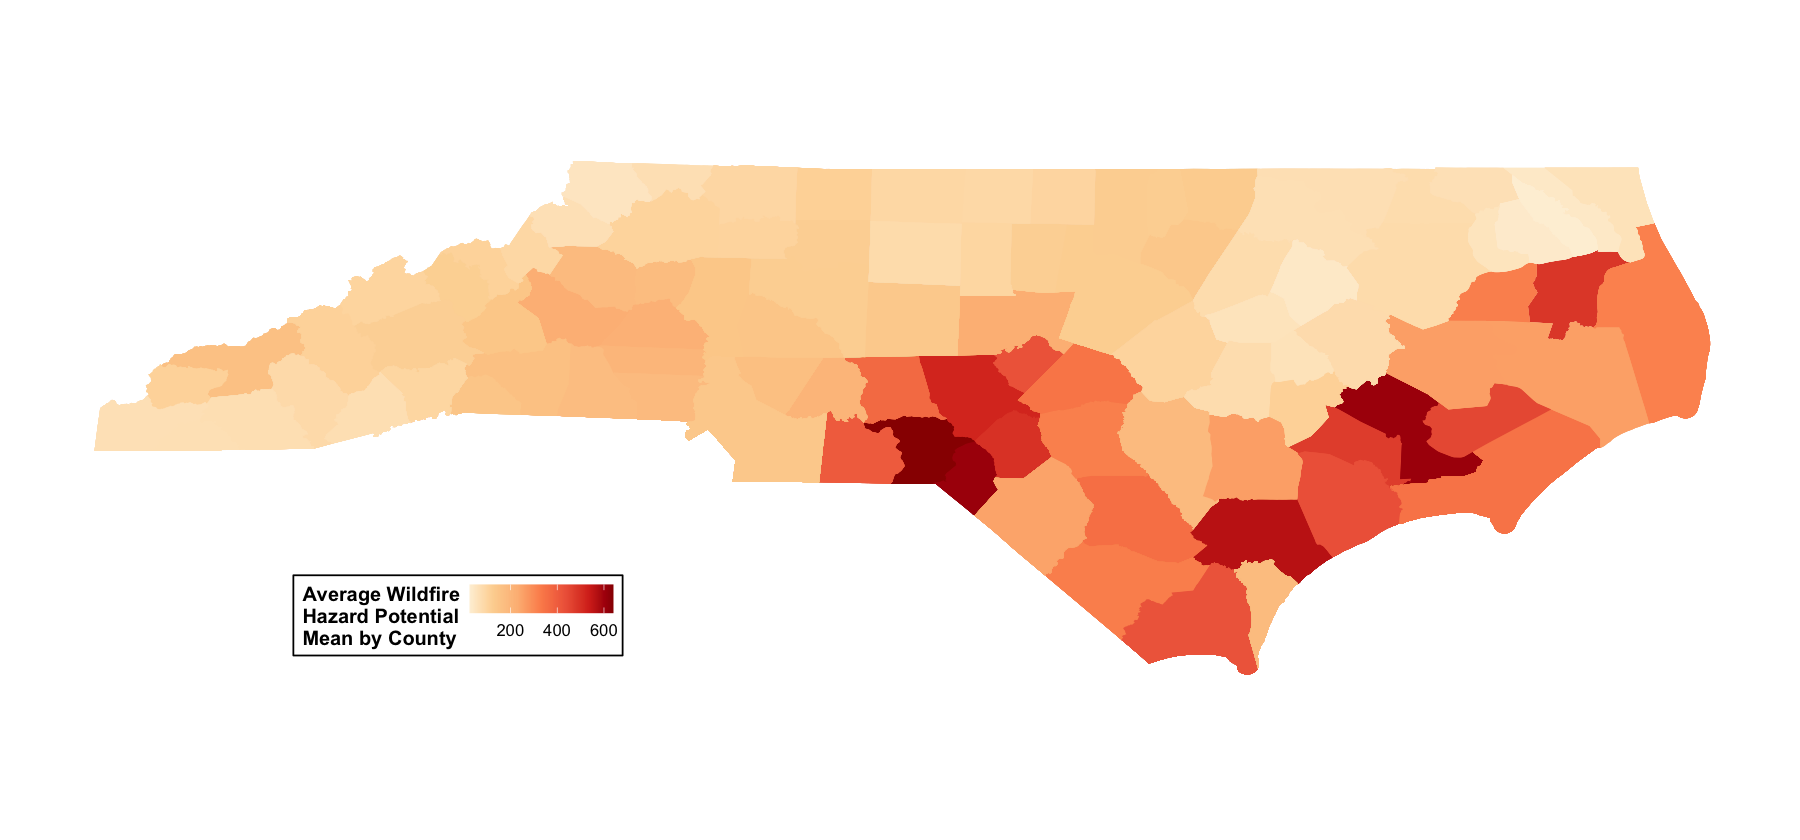

In [7]:
WHP_mean_county_map = ggplot() +
  geom_sf(data = all_data_county, aes(fill = County_Avg_WHP_Mean, geometry = geometry),
          color = NA) + # removes gray lines between geo ids

  theme_bw() + 

  theme(axis.text = element_blank(), # removes x and y labels
      axis.ticks = element_blank(),# removes ticks from x and y labels
      legend.title = element_text(face = 'bold', size = 12), # changes legend title
      legend.text = element_text(size = 10), # changes legend text
      legend.position = c(0.25,0.15), # move legend to bottom left corner
      legend.direction = "horizontal",
      legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
      panel.border = element_blank(), # removes border around the map
      panel.grid.major = element_blank(), # removes grid
      panel.grid.minor = element_blank()) + # removes grid 
  
  scale_fill_gradientn(colors = palette_colors, 
      name = "Average Wildfire\nHazard Potential\nMean by County")

WHP_mean_county_map

### WHP Quintile by County

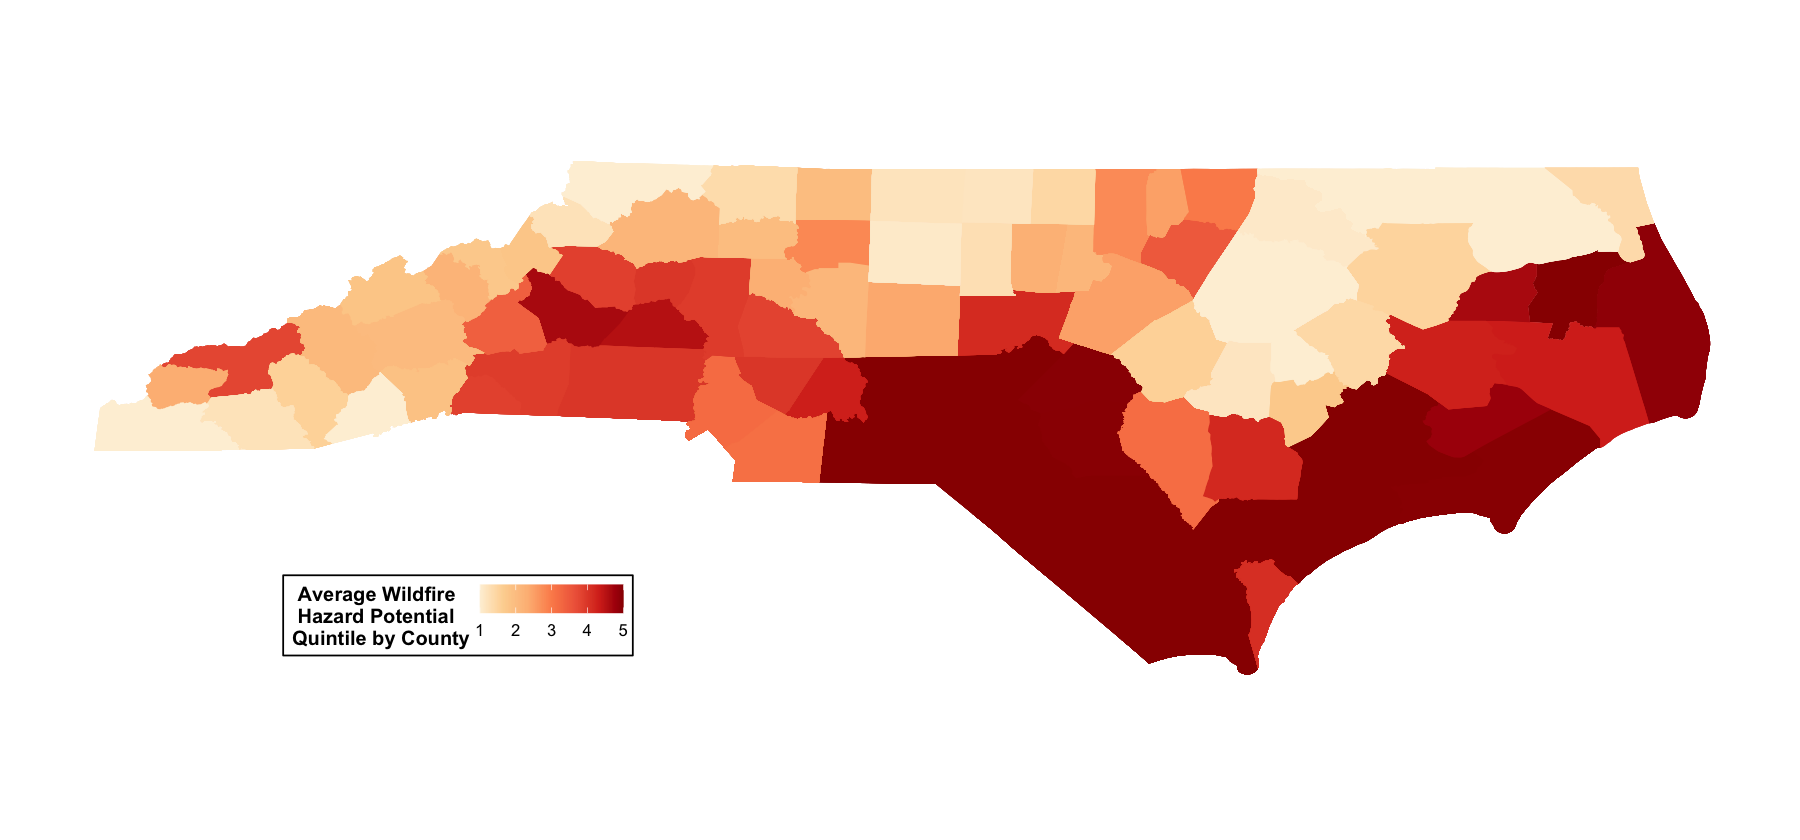

In [8]:
WHP_quintile_county_map = ggplot() +
  geom_sf(data = all_data_county, aes(fill = County_Avg_WHP_Quintile, geometry = geometry), color = NA) + 
  theme_bw() + 

 theme(axis.text = element_blank(), # removes x and y labels
      axis.ticks = element_blank(),# removes ticks from x and y labels
      legend.title = element_text(face = 'bold', size = 12), # changes legend title
      legend.text = element_text(size = 10), # changes legend text
      legend.position = c(0.25,0.15), # move legend to bottom left corner
      legend.direction = "horizontal",
      legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
      panel.border = element_blank(), # removes border around the map
      panel.grid.major = element_blank(), # removes grid
      panel.grid.minor = element_blank()) + # removes grid 
  
  scale_fill_gradientn(colors = palette_colors,
      name = " Average Wildfire\n Hazard Potential\nQuintile by County")

WHP_quintile_county_map

# WHP Maps

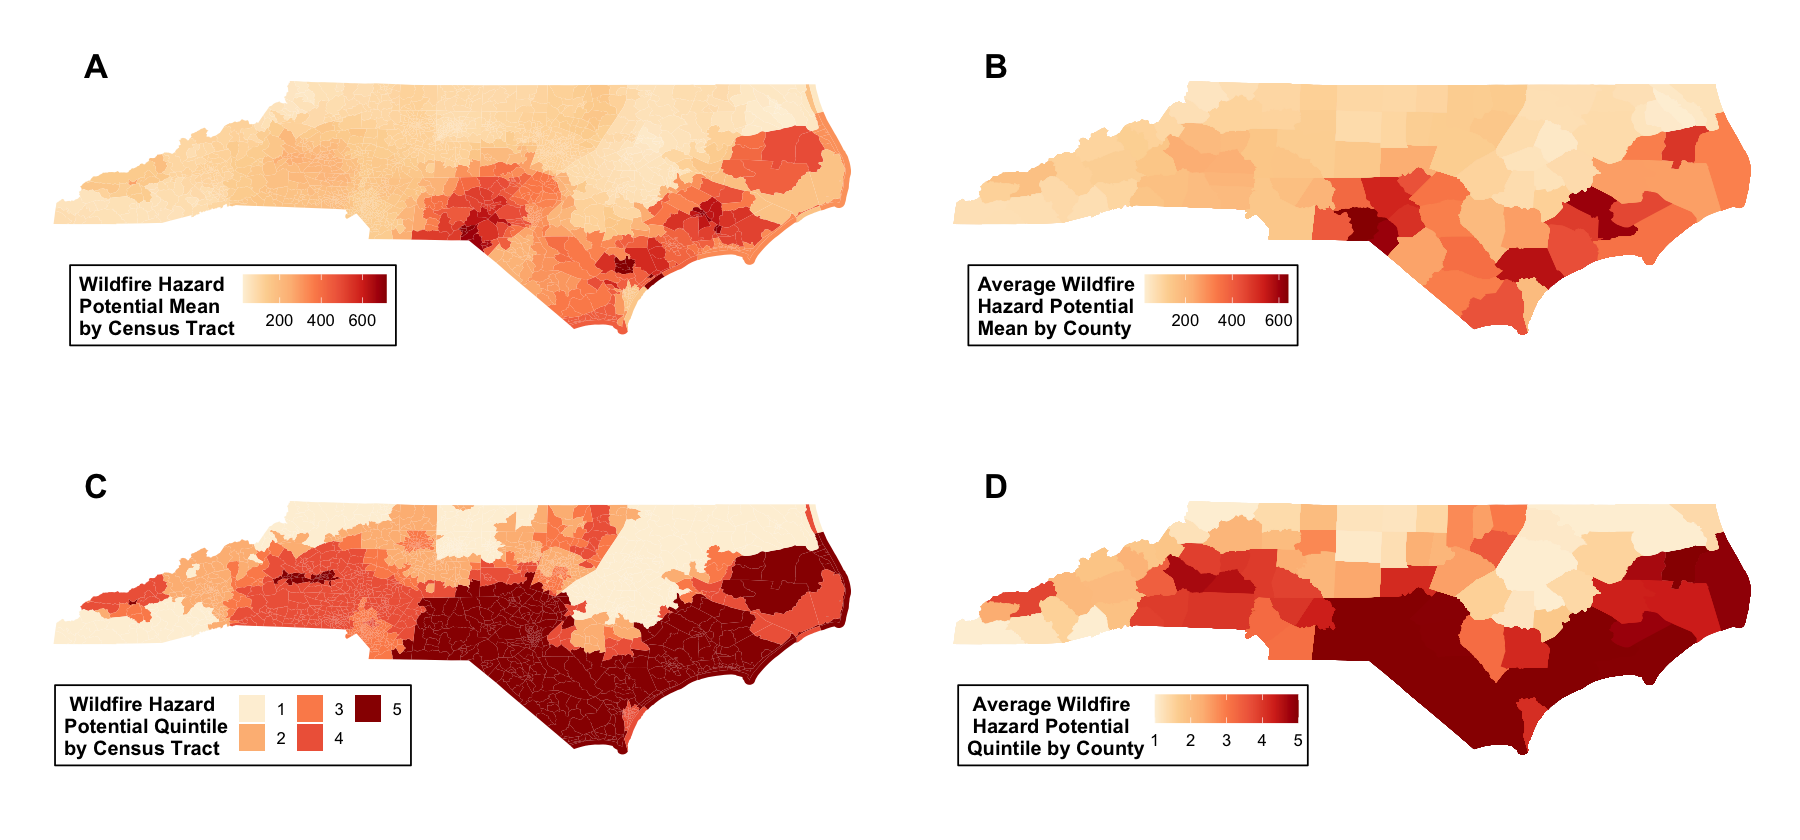

In [9]:
Figure1 = plot_grid(WHP_mean_GEO_ID_map, WHP_mean_county_map, WHP_quintile_GEO_ID_map, WHP_quintile_county_map, 
                            # adding labels, changing size their size and position
                            labels = "AUTO", label_size = 20, label_x = 0.08, label_y = 0.9)
Figure1

In [10]:
# exporting figure
ggsave(Figure1, 
       filename = 'Figure 1.pdf',
       path = Output,
       # need to respecify dimensions here when exporting figures
       width = 15, height = 7)

# GEO ID clustering using EJ Screen Indicators

In [11]:
# adding in clusters
ej_screen_df = full_join(all_data_census_tract, ej_screen_geo_id_clusters)
head(ej_screen_df)

Joining with `by = join_by(GEO_ID, County, Census_Tract)`


,GEO_ID,FIPS,County,Census_Tract,Avg_ACRES,Wildfire_Hazard_Potential_Mean,Wildfire_Hazard_Potential_Quintile_Number,Wildfire_Hazard_Potential_Quintile_Percentage,STATEFP10,COUNTYFP10,⋯,AWATER10,INTPTLAT10,INTPTLON10,COUNTYFP,STATEFP,geometry,Variables,Value,Scaled_Value,Cluster
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<chr>,<chr>,<chr>,<chr>,<MULTIPOLYGON [°]>,<chr>,<dbl>,<dbl>,<chr>
1,14000US37141920201,37141920201,Pender,9202.01,596842.6,715.5177,5,0-20%,37,141,⋯,44942,+34.4018480,-077.6218025,141,37,MULTIPOLYGON (((-77.66061 3...,Population_Under_5,10.0,1.6488531,1
2,14000US37141920201,37141920201,Pender,9202.01,596842.6,715.5177,5,0-20%,37,141,⋯,44942,+34.4018480,-077.6218025,141,37,MULTIPOLYGON (((-77.66061 3...,Population_Over_65,18.3,0.2137770,1
3,14000US37141920201,37141920201,Pender,9202.01,596842.6,715.5177,5,0-20%,37,141,⋯,44942,+34.4018480,-077.6218025,141,37,MULTIPOLYGON (((-77.66061 3...,Race_Non_White,7.9,-0.9882899,1
4,14000US37141920201,37141920201,Pender,9202.01,596842.6,715.5177,5,0-20%,37,141,⋯,44942,+34.4018480,-077.6218025,141,37,MULTIPOLYGON (((-77.66061 3...,Hispanic_Latino,2.8,-0.7410140,1
5,14000US37141920201,37141920201,Pender,9202.01,596842.6,715.5177,5,0-20%,37,141,⋯,44942,+34.4018480,-077.6218025,141,37,MULTIPOLYGON (((-77.66061 3...,Non_Proficient_English_Speakers,1.3,-0.6038880,1
6,14000US37141920201,37141920201,Pender,9202.01,596842.6,715.5177,5,0-20%,37,141,⋯,44942,+34.4018480,-077.6218025,141,37,MULTIPOLYGON (((-77.66061 3...,Poverty_Overall,4.5,-1.0665186,1


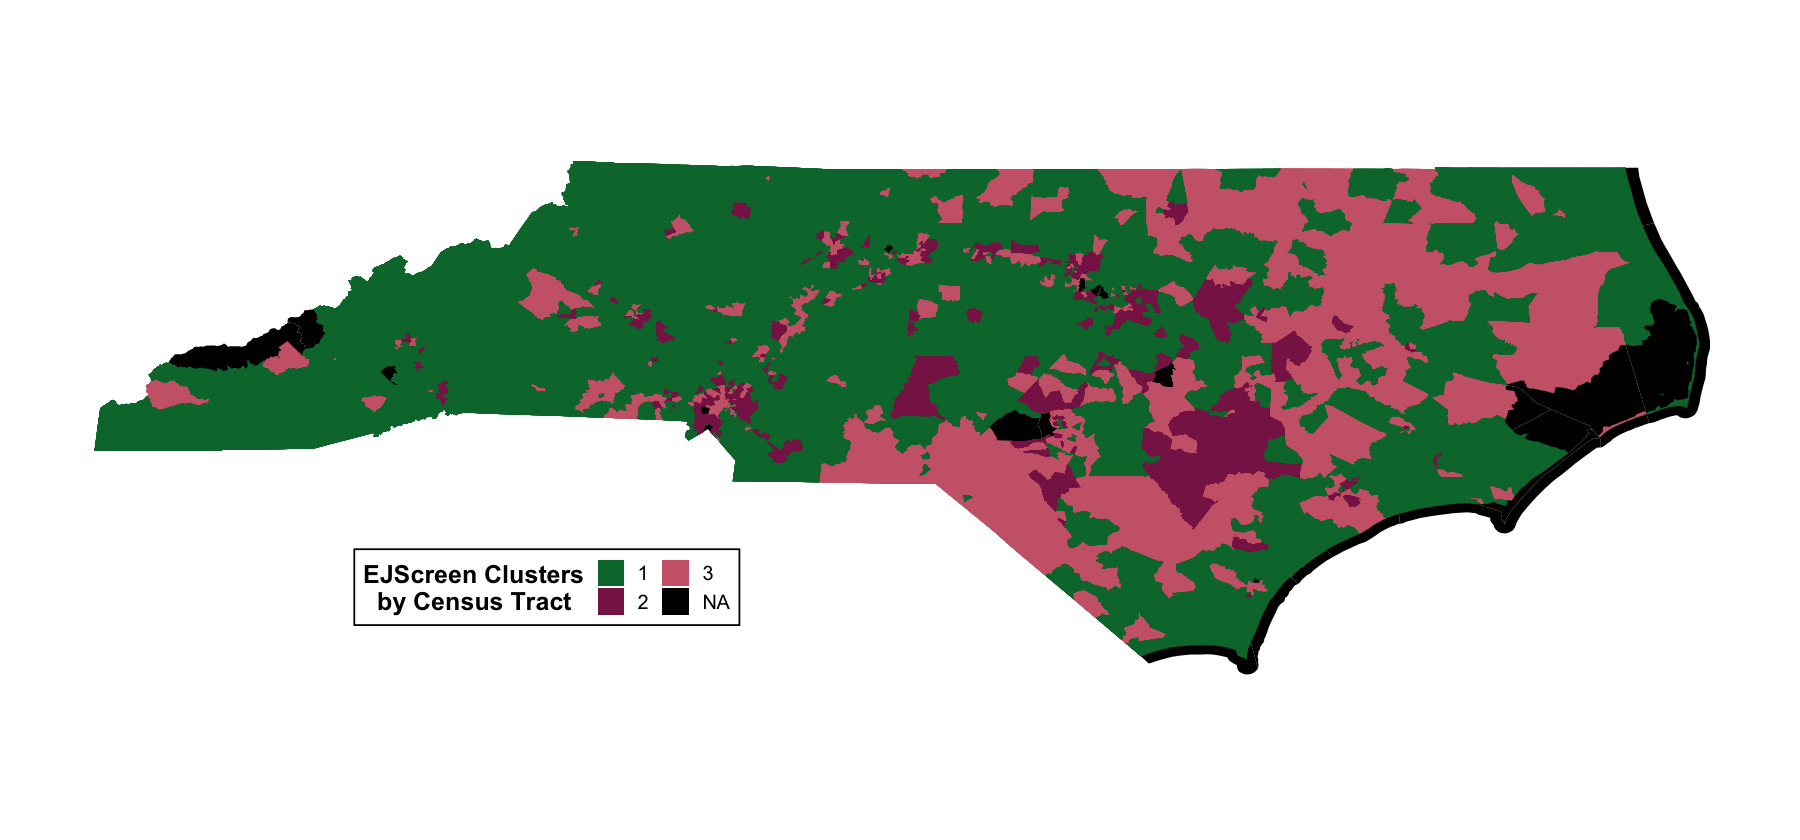

In [12]:
options(repr.plot.width=15, repr.plot.height=7) #changing size

# getting color palette
prism_colors = carto_pal(12, "Safe")

Figure4a = ggplot() +
  geom_sf(data = ej_screen_df, aes(fill = Cluster, geometry = geometry), 
          color = NA) + # removes gray lines between geo ids

  theme_bw() + 

    theme(axis.text = element_blank(), # removes x and y labels
      axis.ticks = element_blank(),# removes ticks from x and y labels
      legend.title = element_text(face = 'bold', size = 15), # changes legend title
      legend.text = element_text(size = 12), # changes legend text
      legend.position = c(0.3,0.2), # move legend to bottom left corner
      legend.direction = "horizontal",
      legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
      panel.border = element_blank(), # removes border around the map
      panel.grid.major = element_blank(), # removes grid
      panel.grid.minor = element_blank()) + # removes grid 
 
  scale_fill_manual(values = c("#027639", prism_colors[c(9,2)]), 
                    na.value = "black", # making geo ids w/ NA values black
                    name = "EJScreen Clusters\n  by Census Tract") + 

 guides(fill = guide_legend(nrow = 2)) # making the quintiles in the legend into rows

Figure4a

Plotting the average scaled value for each variable within each cluster to visualize the magnitude and directionality of each variable.

In [13]:
# combining each into 1 df
# ejscreen
averaged_ejscreen_df = ej_screen_geo_id_clusters %>%
    # averaging values for each variable within each cluster
    group_by(Cluster, Variables) %>%
    summarize(Avg_Scaled_Value = mean(Scaled_Value), Avg_Value = mean(Value)) %>%
    # lastly arranging variables from highest to lowest within each cluster
    arrange(-Avg_Scaled_Value, .by_group = TRUE) %>%
    ungroup() %>%
    # cleaning variable names here
    mutate(Variables = ifelse(Variables == "Non_Proficient_English_Speakers", "Non-proficient English Speakers",
                                  ifelse(Variables == "Less_than_High_School", "Less than High School Education",
                                      ifelse(Variables == "Population_Over_65", "Over 65 Years Old",
                                         ifelse(Variables == "Population_Under_5", "Under 5 Years Old",
                                             ifelse(Variables == "Hispanic_Latino", "Hispanic and/or Latino",
                                                ifelse(Variables == "Poverty_Overall", "Below Federal Poverty Level",
                                                    ifelse(Variables == "Race_Non_White", "Non-White Population",
                                                           ifelse(Variables == "Unemployed", Variables,
                             NA)))))))))

averaged_ejscreen_df$Cluster = as.character(averaged_ejscreen_df$Cluster)

head(averaged_ejscreen_df)

`summarise()` has grouped output by 'Cluster'. You can override using the
`.groups` argument.


Cluster,Variables,Avg_Scaled_Value,Avg_Value
<chr>,<chr>,<dbl>,<dbl>
1,Over 65 Years Old,0.3058091,18.997422
1,Under 5 Years Old,-0.2717533,5.043984
1,Non-proficient English Speakers,-0.3493582,2.610937
1,Unemployed,-0.3635031,4.332424
1,Hispanic and/or Latino,-0.3789516,5.873047
1,Less than High School Education,-0.3838343,19.530495


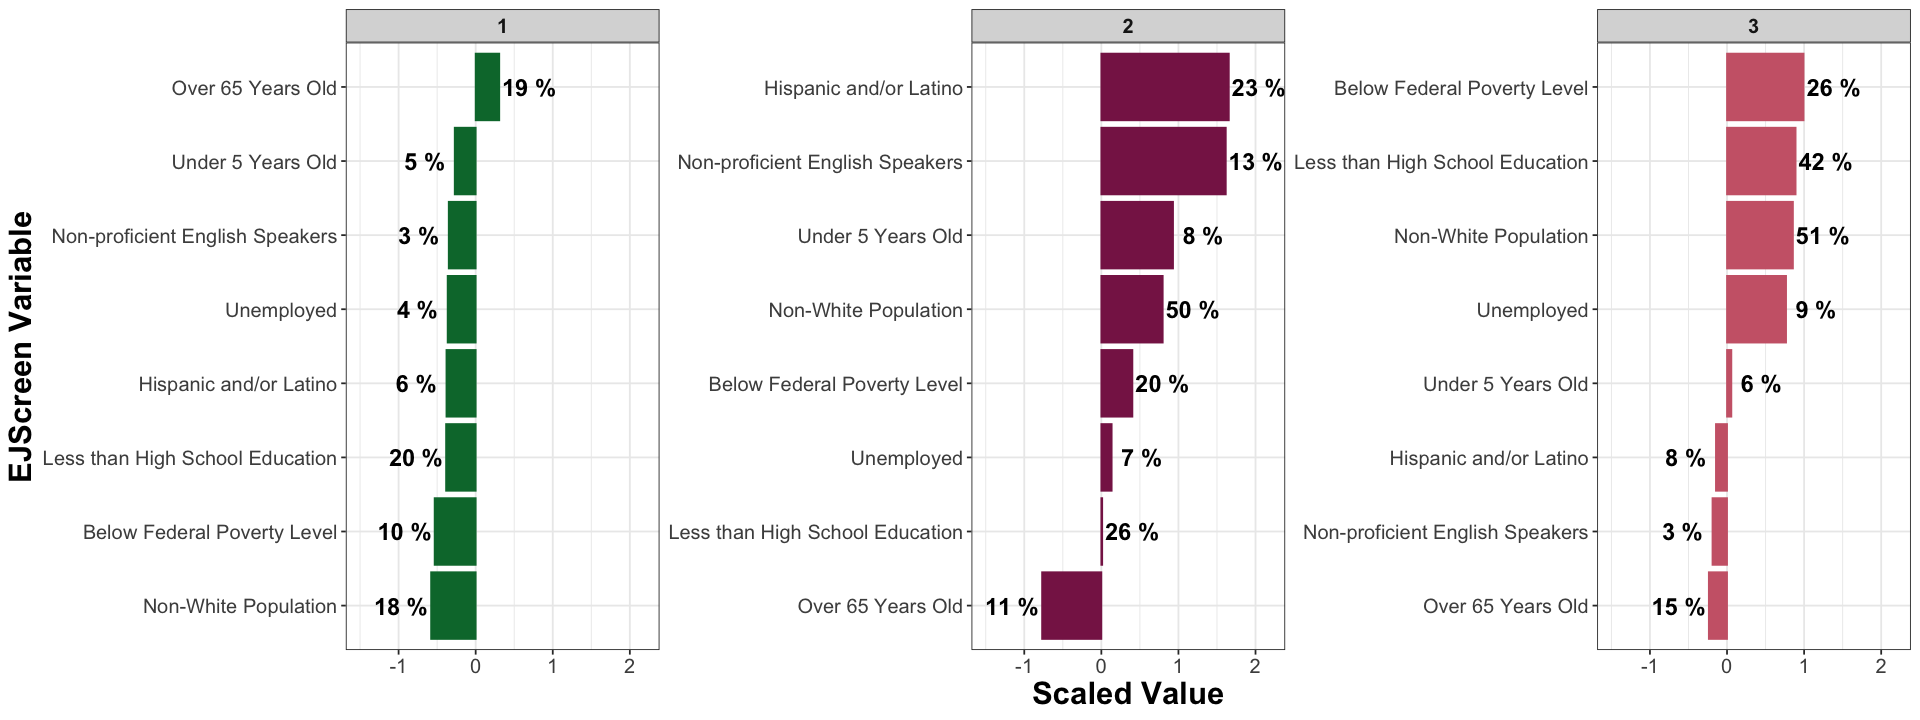

In [14]:
options(repr.plot.width = 16, repr.plot.height = 6) #changing size

# getting color palette
prism_colors = carto_pal(12, "Safe")

Figure4b = ggplot() + 
  geom_col(data = averaged_ejscreen_df, aes(x = Avg_Scaled_Value, 
                                            y = reorder_within(Variables, Avg_Scaled_Value, Cluster), 
                                            color = Cluster, fill = Cluster)) + 
  # adding in original values for clarity
  geom_text(data = averaged_ejscreen_df %>%
                filter(Avg_Scaled_Value > 0), aes(x = Avg_Scaled_Value + 0.39, label = paste(round(Avg_Value),"%"), 
                y = reorder_within(Variables, Avg_Scaled_Value, Cluster)), fontface = "bold", size = 5) +
  geom_text(data = averaged_ejscreen_df %>%
                filter(Avg_Scaled_Value < 0), aes(x = Avg_Scaled_Value - 0.39, label = paste(round(Avg_Value),"%"), 
                y = reorder_within(Variables, Avg_Scaled_Value, Cluster)), fontface = "bold", size = 5) +

  xlim(-1.5,2.2) + 
  scale_y_reordered() + # for some reason this cleans up the variables names

  facet_wrap(~Cluster, scales = 'free_y') + 
  theme_bw() + #changing theme
  theme(axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text = element_text(size = 12, face = "bold"), #changing facet wrap text
        legend.position = "none") + #removing legend

  scale_color_manual(values = c("#027639", prism_colors[c(9,2)])) +
  scale_fill_manual(values = c("#027639", prism_colors[c(9,2)])) +

  labs(y = 'EJScreen Variable', x = "Scaled Value")

Figure4b

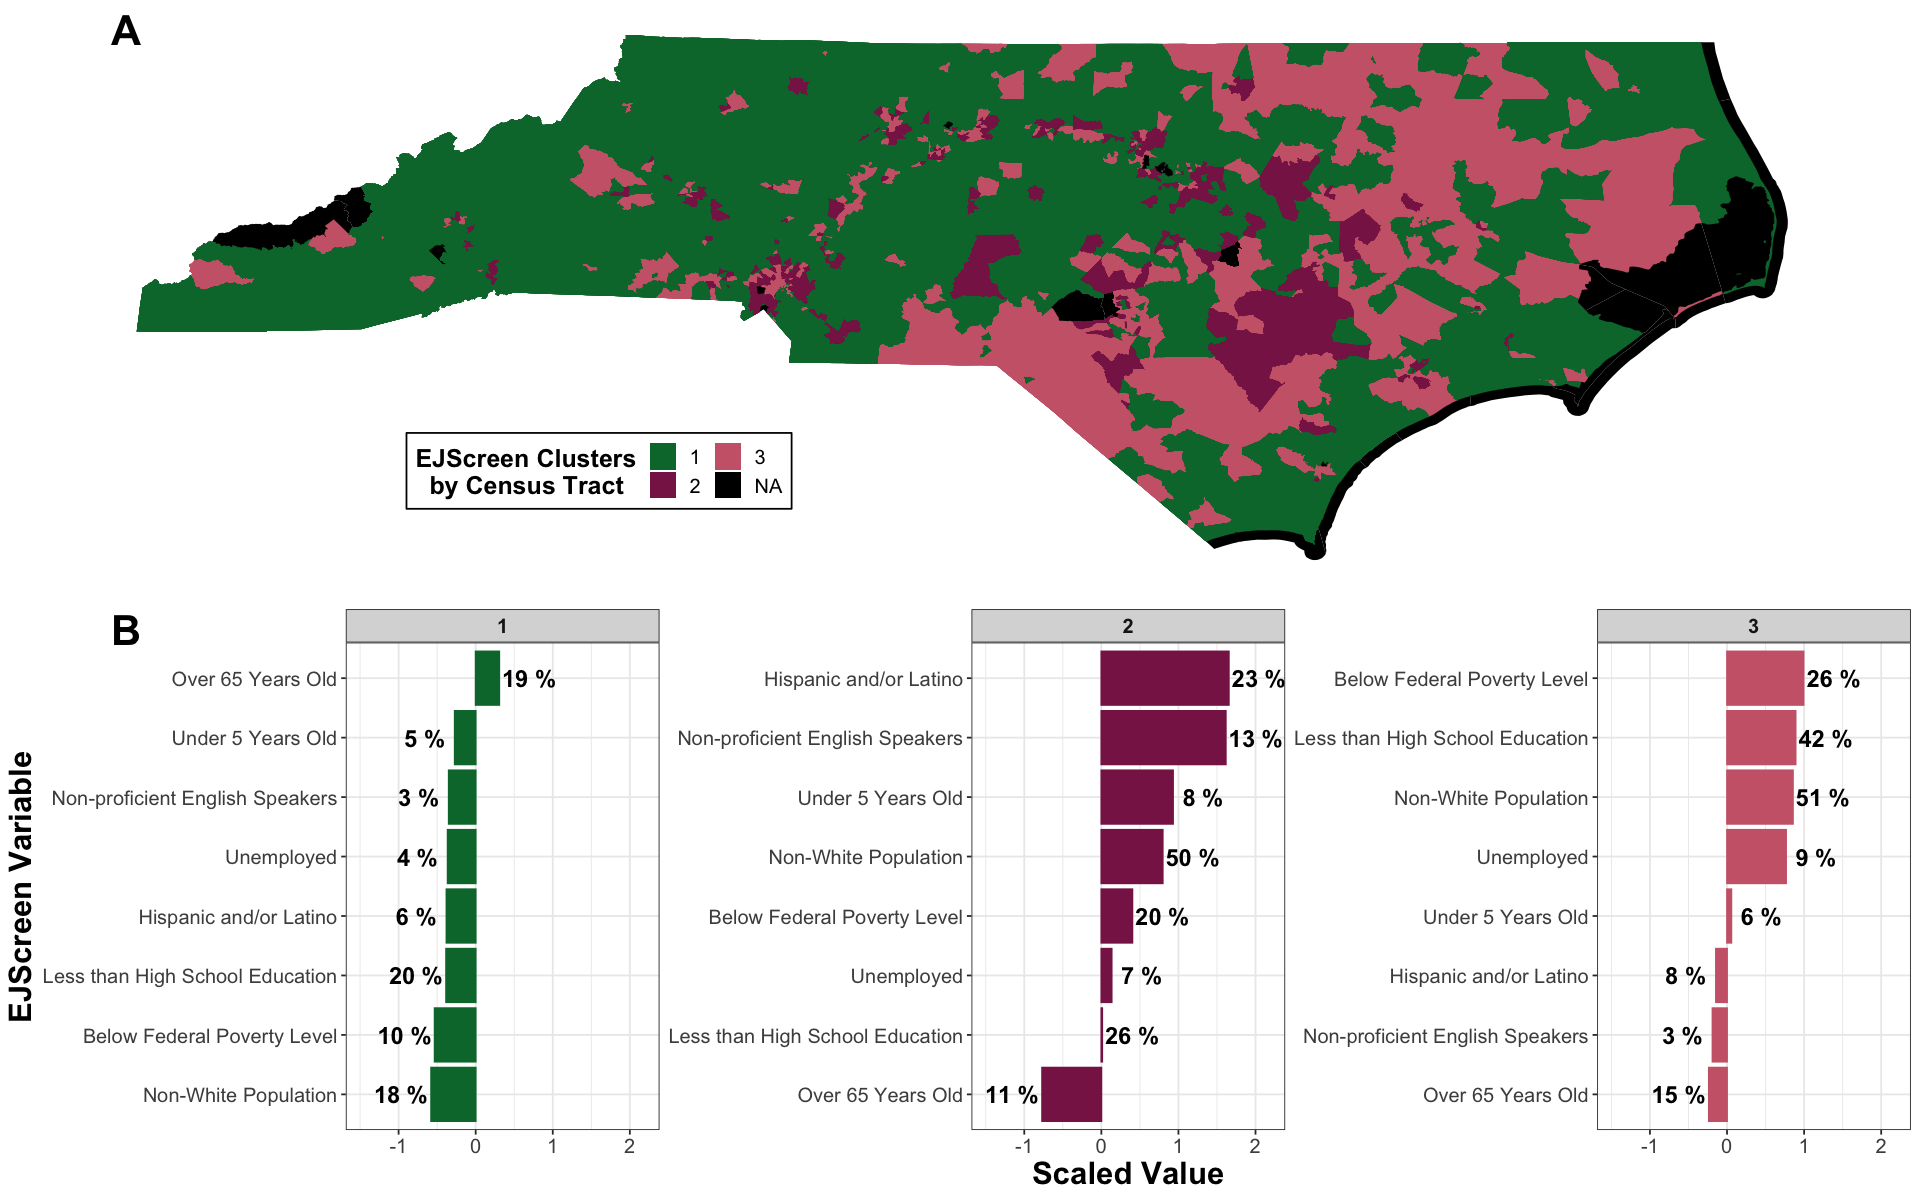

In [15]:
options(repr.plot.width = 16, repr.plot.height = 10) #changing size
Figure4 = plot_grid(Figure4a, Figure4b,
                            # adding labels, changing size their size and position
                            labels = "AUTO", label_size = 25, label_x = 0.05, label_y = 1, ncol = 1)
Figure4

In [16]:
# exporting figure
ggsave(Figure, 
       filename = 'Figure 4.pdf',
       path = Output,
       # need to respecify dimensions here when exporting figures
       width = 16, height = 10)